In [33]:
import pandas as pd
import numpy as np
import warnings
import time

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error
from sklearn.model_selection import ParameterGrid
from scipy.stats import pearsonr


import prophet

warnings.filterwarnings('ignore')

In [2]:
# suppress the prophet logs
import logging

class SuppressFilter(logging.Filter):
    def filter(self, record):
        return False  

logger = logging.getLogger('cmdstanpy')
logger.addFilter(SuppressFilter())

# Prophet Multivariate

In [11]:
# read datasets 
enc = pd.read_csv('../../data/regional_datasets/multivariate/enc_data_multi.csv')
esc = pd.read_csv('../../data/regional_datasets/multivariate/esc_data_multi.csv')
mid_atlantic = pd.read_csv('../../data/regional_datasets/multivariate/mid_atlantic_data_multi.csv')
mountain = pd.read_csv('../../data/regional_datasets/multivariate/mountain_data_multi.csv')
new_england = pd.read_csv('../../data/regional_datasets/multivariate/new_england_data_multi.csv')
pacific = pd.read_csv('../../data/regional_datasets/multivariate/pacific_data_multi.csv')
south_atlantic = pd.read_csv('../../data/regional_datasets/multivariate/south_atlantic_data_multi.csv')
wnc = pd.read_csv('../../data/regional_datasets/multivariate/wnc_data_multi.csv')
wsc = pd.read_csv('../../data/regional_datasets/multivariate/wsc_data_multi.csv')
datasets = [enc, esc, mid_atlantic, mountain, new_england, pacific, south_atlantic, wnc, wsc]
for df in datasets:
    df['date'] = pd.to_datetime(df['date'])
    df.drop(columns=["Unnamed: 0"], axis=1, inplace=True)
    df.sort_index(inplace=True)
    df.rename(columns={'date': 'ds', 'new_confirmed': 'y'}, inplace=True)


In [62]:
def build_multi_prophet(df, features=None, plot=False):
    region = df["region"].iloc[0]
    print(f"Training model for {region}...")

    df = df.replace([np.nan], 0)

    if features is None:
        features = df.columns.drop(['ds', 'y', 'region', 'location_key'], errors='ignore')

    size = round(df.shape[0]*0.15)
    train = df.iloc[:-size]
    test = df.iloc[-size:]
    test_y = test['y']

    model = prophet.Prophet()
    for feature in features:
        model.add_regressor(feature, standardize=False)
    model = model.fit(train)

    # pred, conf_int = model.predict(n_periods=size, return_conf_int=True)
    pred = model.predict(test)
    pred_yhat = pred['yhat']

    # calculate metrics
    mae = mean_absolute_error(test_y, pred_yhat)
    mse = mean_squared_error(test_y, pred_yhat)
    rmse = mean_squared_error(test_y, pred_yhat, squared=False)
    mase = mean_absolute_scaled_error(test_y, pred_yhat, y_train=train['y'])

    print(f'MAE: {round(mae, 2)}')
    print(f'MSE: {round(mse, 2)}')
    print(f'RMSE: {round(rmse, 2)}')
    print(f'MASE: {round(mase, 2)}')

    # plot predictions
    if plot:
        plt.figure(figsize=(15, 5))
        plt.title(f'Multivariate Prophet Predictions for {region}')
        plt.plot(test['ds'], test_y, label='True')
        plt.plot(pred['ds'], pred_yhat, label='Predicted')
        # uncomment to show confidence interval
        # plt.fill_between(test.index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')
        plt.legend() 
        plt.show()

Training model for East North Central...


Optimization terminated abnormally. Falling back to Newton.


MAE: 107074.2
MSE: 195338048829.56
RMSE: 441970.64
MASE: 12.35


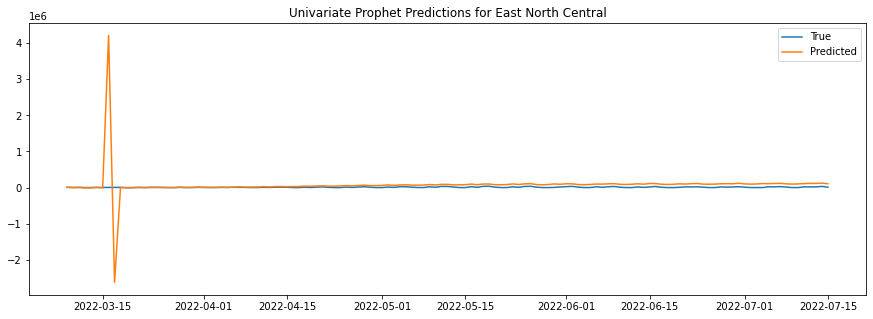


Training model for East South Central...


Optimization terminated abnormally. Falling back to Newton.


MAE: 26651.23
MSE: 39655626216.37
RMSE: 199137.2
MASE: 7.35


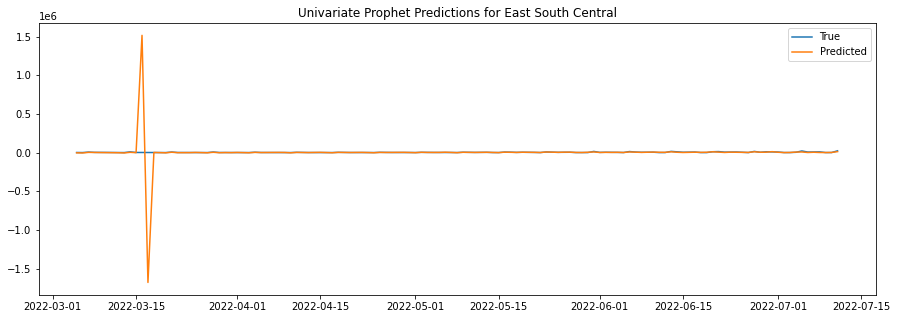


Training model for Mid-Atlantic...


Optimization terminated abnormally. Falling back to Newton.


MAE: 9736.81
MSE: 508327901.54
RMSE: 22546.13
MASE: 4.27


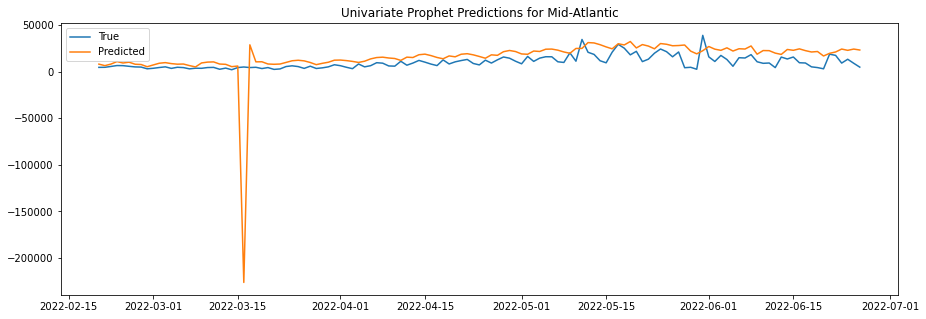


Training model for Mountain...


Optimization terminated abnormally. Falling back to Newton.


MAE: 40784.59
MSE: 83402520212.25
RMSE: 288794.94
MASE: 12.2


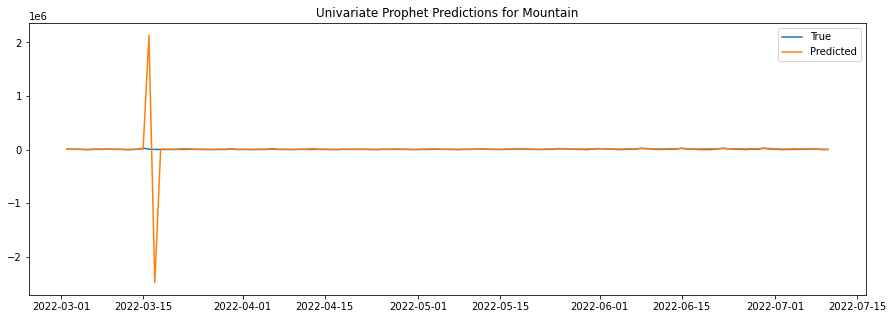


Training model for New England...


Optimization terminated abnormally. Falling back to Newton.


MAE: 6374.44
MSE: 928147813.71
RMSE: 30465.52
MASE: 2.36


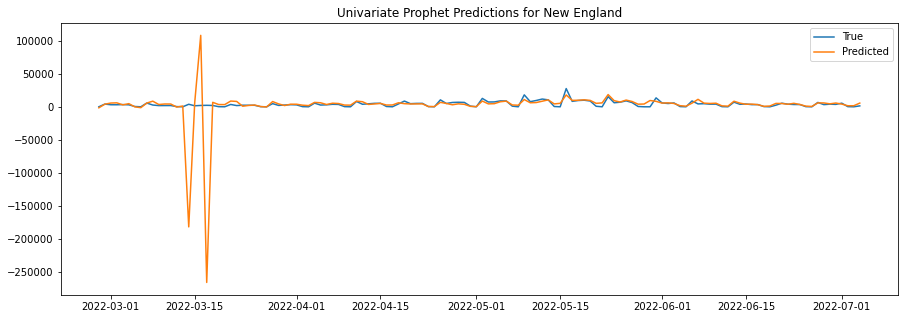


Training model for Pacific...


Optimization terminated abnormally. Falling back to Newton.


MAE: 32171.17
MSE: 39107079325.43
RMSE: 197755.1
MASE: 4.48


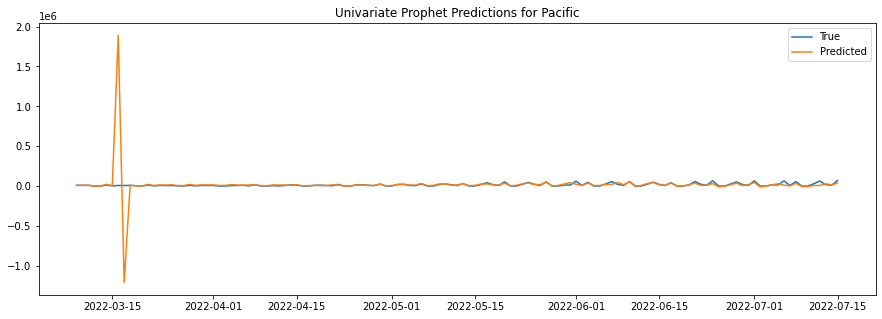


Training model for South Atlantic...


Optimization terminated abnormally. Falling back to Newton.


MAE: 153568.35
MSE: 1310259885401.47
RMSE: 1144665.84
MASE: 13.25


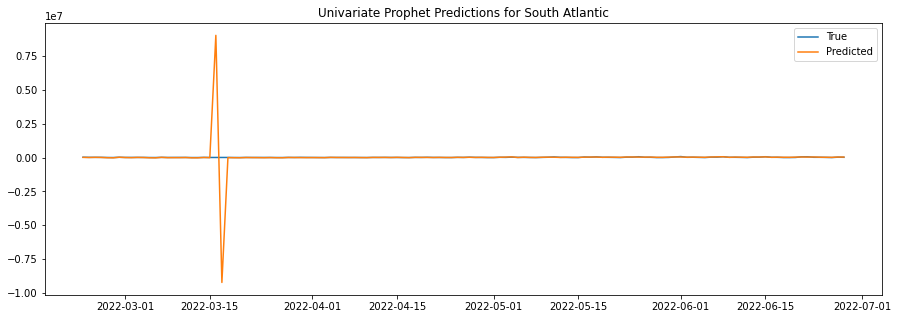


Training model for West North Central...


Optimization terminated abnormally. Falling back to Newton.


MAE: 130121.75
MSE: 845177972458.02
RMSE: 919335.61
MASE: 37.91


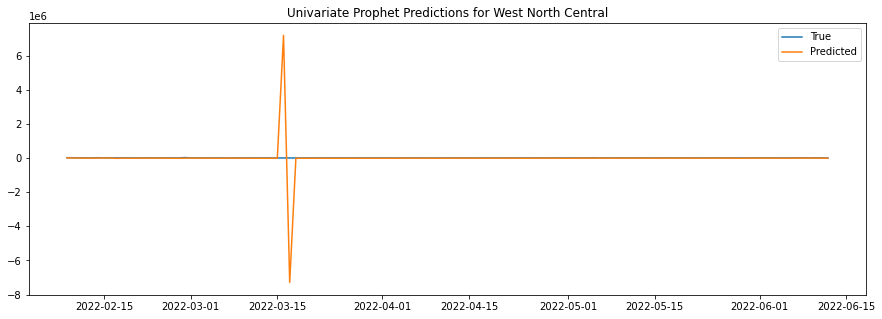


Training model for West South Central...


Optimization terminated abnormally. Falling back to Newton.


MAE: 16749.78
MSE: 3432542540.83
RMSE: 58587.9
MASE: 3.45


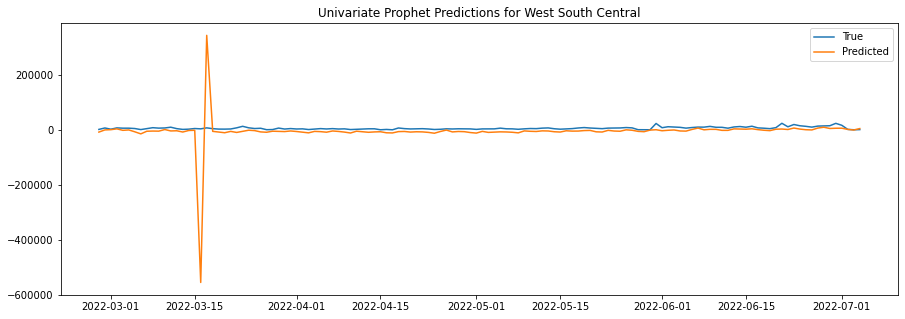


--- 30.49 seconds ---


In [32]:
start_time = time.time()
for df in datasets:
    build_multi_prophet(df, plot=True)
    print("")
print(f"--- {round(time.time() - start_time, 2)} seconds ---")

clearly some features are creating an unnatural spike in the predictions, going to do feature selection through correlation to fi x

## Feature Selection

In [51]:
def feat2resp_correlation(df, threshold=0.5):
    region = df["region"].iloc[0]
    print(f"Correlation for {region}...")

    df = df.replace([np.nan], 0)

    features = df.columns.drop(['ds', 'y', 'region', 'location_key'], errors='ignore')

    corr = []
    for feature in features:
        pearson_corr, p_value = pearsonr(df['y'], df[feature])
        corr.append(pearson_corr)
    
    res = pd.DataFrame({'feature': features, 'correlation': corr})
    res['correlation'] = res['correlation'].abs()
    res = res.sort_values(by='correlation', ascending=False)
    cut = res[res['correlation'] > threshold]

    print(cut.shape[0], list(cut["feature"]))

In [53]:
for df in datasets:
    feat2resp_correlation(df, threshold=0.3)
    print("")

Correlation for East North Central...
13 ['7_day_shift', '7_day_avg', 'new_hospitalized_patients', 'current_hospitalized_patients', '2_day_shift', '1_day_shift', 'new_deceased', 'current_intensive_care_patients', 'maximum_temperature_celsius', 'average_temperature_celsius', 'minimum_temperature_celsius', 'dew_point', 'income_support']

Correlation for East South Central...
12 ['7_day_avg', '7_day_shift', 'current_hospitalized_patients', '3_day_shift', '1_day_shift', 'new_hospitalized_patients', '2_day_shift', 'current_intensive_care_patients', 'new_deceased', 'maximum_temperature_celsius', 'average_temperature_celsius', 'testing_policy']

Correlation for Mid-Atlantic...
13 ['7_day_avg', '1_day_shift', '2_day_shift', '8_day_shift', '9_day_shift', 'current_hospitalized_patients', 'new_hospitalized_patients', 'maximum_temperature_celsius', 'average_temperature_celsius', 'current_intensive_care_patients', 'minimum_temperature_celsius', 'dew_point', 'international_travel_controls']

Correla

In [58]:
first_fs = {
    "East North Central": ['7_day_shift', '7_day_avg', 'new_hospitalized_patients', 'current_hospitalized_patients', '2_day_shift', '1_day_shift', 'new_deceased', 'current_intensive_care_patients', 'maximum_temperature_celsius', 'average_temperature_celsius', 'minimum_temperature_celsius', 'dew_point', 'income_support'],
    "East South Central": ['7_day_avg', '7_day_shift', 'current_hospitalized_patients', '3_day_shift', '1_day_shift', 'new_hospitalized_patients', '2_day_shift', 'current_intensive_care_patients', 'new_deceased', 'maximum_temperature_celsius', 'average_temperature_celsius', 'testing_policy'],
    "Mid-Atlantic": ['7_day_avg', '1_day_shift', '2_day_shift', '8_day_shift', '9_day_shift', 'current_hospitalized_patients', 'new_hospitalized_patients', 'maximum_temperature_celsius', 'average_temperature_celsius', 'current_intensive_care_patients', 'minimum_temperature_celsius', 'dew_point', 'international_travel_controls'],
    "Mountain": ['7_day_avg', '7_day_shift', 'new_hospitalized_patients', '6_day_shift', '1_day_shift', 'current_hospitalized_patients', 'current_intensive_care_patients', 'new_deceased', 'maximum_temperature_celsius', 'average_temperature_celsius', 'minimum_temperature_celsius', 'relative_humidity', 'income_support'],
    "New England": ['7_day_shift', '7_day_avg', '1_day_shift', 'current_hospitalized_patients', 'minimum_temperature_celsius', 'average_temperature_celsius', 'maximum_temperature_celsius', 'dew_point', 'international_travel_controls', 'new_hospitalized_patients', 'current_intensive_care_patients'],
    "Pacific": ['7_day_shift', '7_day_avg', '3_day_shift', '1_day_shift', 'new_hospitalized_patients', '10_day_shift', 'current_hospitalized_patients', 'current_intensive_care_patients', 'relative_humidity', 'international_travel_controls'],
    "South Atlantic": ['7_day_avg', '7_day_shift', 'new_hospitalized_patients', '6_day_shift', 'current_hospitalized_patients', '1_day_shift', 'current_intensive_care_patients', 'new_deceased'],
    "West North Central": ['7_day_shift', '7_day_avg', 'new_hospitalized_patients', '1_day_shift', 'current_hospitalized_patients', '6_day_shift', 'current_intensive_care_patients', 'new_deceased', 'minimum_temperature_celsius', 'average_temperature_celsius', 'dew_point'],
    "West South Central": ['7_day_avg', '7_day_shift', '1_day_shift', 'new_hospitalized_patients', 'current_hospitalized_patients', 'current_intensive_care_patients', 'dew_point', 'new_deceased', 'average_temperature_celsius', 'maximum_temperature_celsius'],

}

Training model for East North Central...
MAE: 4443.94
MSE: 29720338.12
RMSE: 5451.64
MASE: 0.51


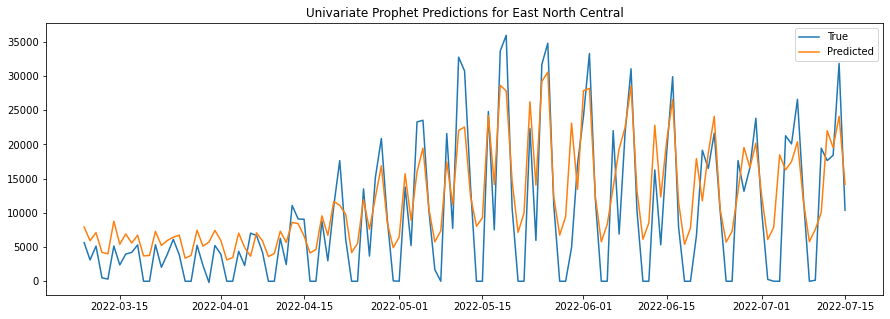


Training model for East South Central...
MAE: 2372.05
MSE: 8854497.44
RMSE: 2975.65
MASE: 0.65


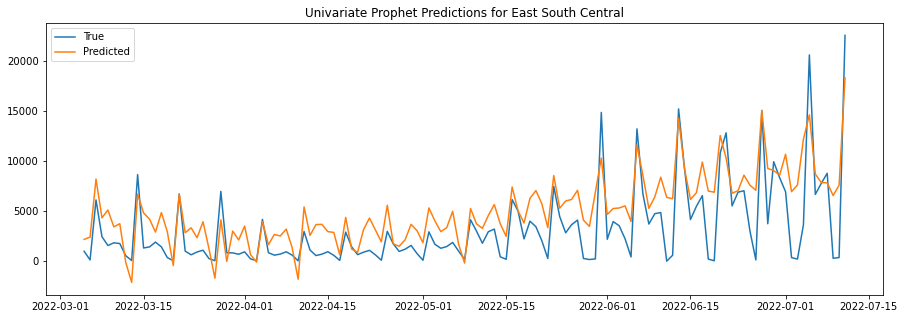

Optimization terminated abnormally. Falling back to Newton.



Training model for Mid-Atlantic...
MAE: 3593.54
MSE: 25251243.48
RMSE: 5025.06
MASE: 1.57


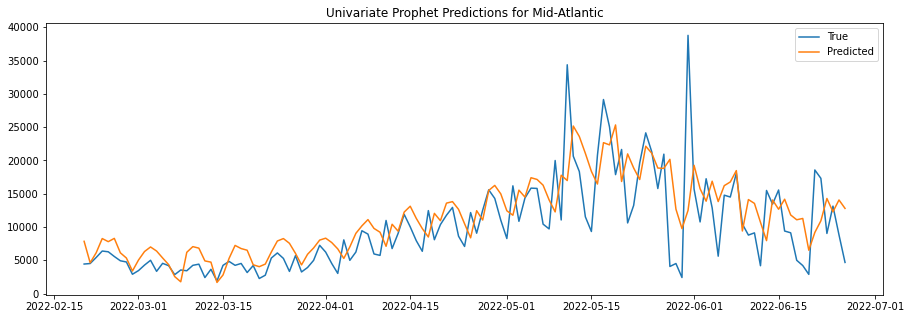


Training model for Mountain...
MAE: 9961.45
MSE: 123239706.82
RMSE: 11101.34
MASE: 2.98


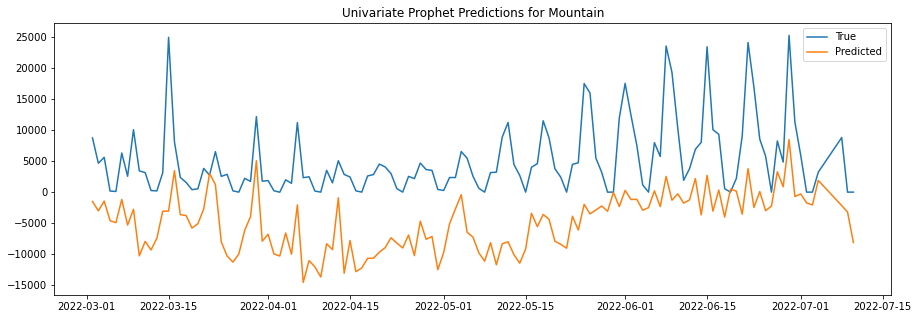


Training model for New England...
MAE: 1769.0
MSE: 6183137.5
RMSE: 2486.59
MASE: 0.65


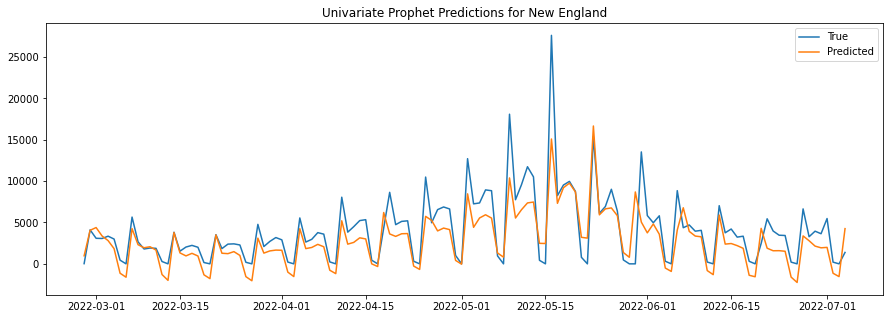


Training model for Pacific...


Optimization terminated abnormally. Falling back to Newton.


MAE: 8034.72
MSE: 140758463.7
RMSE: 11864.17
MASE: 1.12


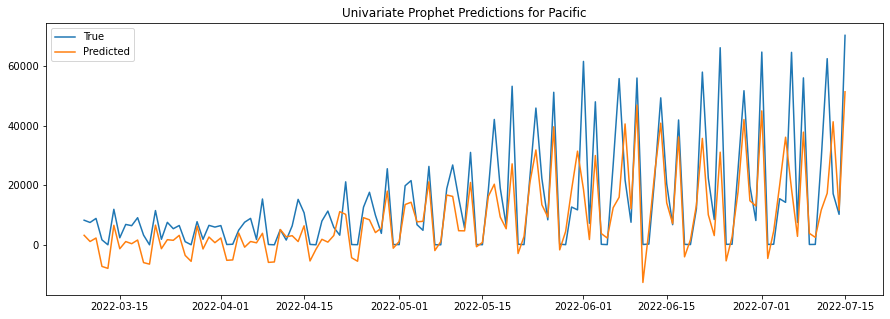


Training model for South Atlantic...


Optimization terminated abnormally. Falling back to Newton.


MAE: 10447.1
MSE: 180782197.25
RMSE: 13445.53
MASE: 0.9


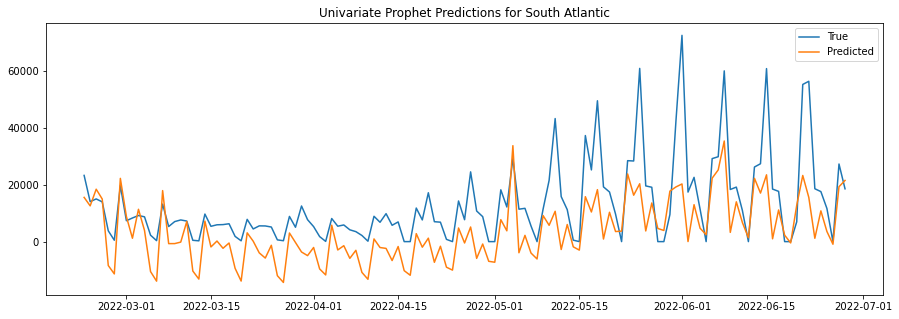


Training model for West North Central...
MAE: 13645.79
MSE: 196613158.11
RMSE: 14021.88
MASE: 3.98


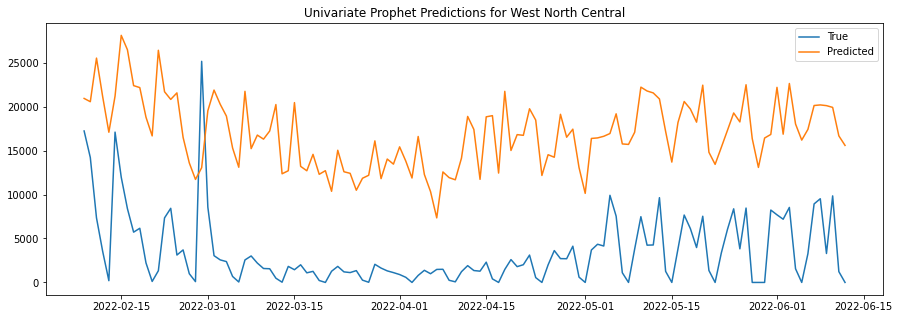


Training model for West South Central...
MAE: 8758.36
MSE: 89172131.52
RMSE: 9443.1
MASE: 1.8


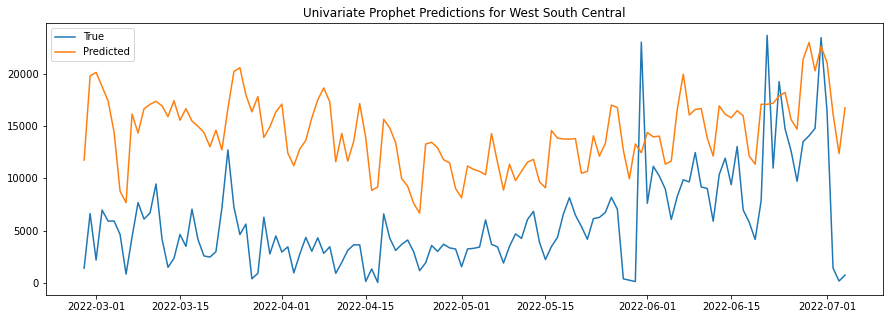


--- 9.68 seconds ---


In [59]:
start_time = time.time()
for df in datasets:
    build_multi_prophet(df, features=first_fs[df["region"].iloc[0]], plot=True)
    print("")
print(f"--- {round(time.time() - start_time, 2)} seconds ---")

## Parameter Optimization

In [85]:
params_grid = {
    'changepoint_prior_scale':[0.001,0.005,0.01,0.025, 0.05, 0.1],
    'seasonality_prior_scale':[0.1,0.25,0.5,1,2,5],
    # 'yearly_seasonality': [True, 'auto'],
    # 'weekly_seasonality': [True, 'auto'],
    # 'changepoint_prior_scale': [0.01, 0.1, 0.5],
    # 'seasonality_prior_scale': [0.1, 1.0, 5.0, 10.0],
            }
grid = ParameterGrid(params_grid)
def optimize_parameters(df, features=None):
    region = df["region"].iloc[0]
    print(f"Training model for {region}...")

    df = df.replace([np.nan], 0)

    if features is None:
        features = df.columns.drop(['ds', 'y', 'region', 'location_key'], errors='ignore')

    size = round(df.shape[0]*0.15)
    train = df.iloc[:-size]
    test = df.iloc[-size:]
    test_y = test['y']

    results = []
    for params in grid:

        model = prophet.Prophet(**params)
        model.add_country_holidays(country_name='US')
        for feature in features:
            model.add_regressor(feature, standardize=False)
        model = model.fit(train)

        # pred, conf_int = model.predict(n_periods=size, return_conf_int=True)
        pred = model.predict(test)
        pred_yhat = pred['yhat']

        # calculate metrics
        mae = mean_absolute_error(test_y, pred_yhat)
        rmse = mean_squared_error(test_y, pred_yhat, squared=False)
        mase = mean_absolute_scaled_error(test_y, pred_yhat, y_train=train['y'])

        results.append([params["changepoint_prior_scale"], params["seasonality_prior_scale"], mae, rmse, mase])
                
    results = pd.DataFrame(results, columns=["changepoint_prior_scale", "seasonality_prior_scale", "mae", "rmse", "mase"])
    results.sort_values(by="mase", inplace=True)
    print(results.head())


In [78]:
optimize_parameters(enc, features=first_fs["East North Central"])

Training model for East North Central...


Optimization terminated abnormally. Falling back to Newton.


,changepoint_prior_scale,seasonality_prior_scale,mae,rmse,mase
7,0.005,0.25,3543.109292,4896.387390,0.408745
17,0.010,5.00,4443.862375,5451.397048,0.512659
14,0.010,0.50,4443.862375,5451.397048,0.512659
13,0.010,0.25,4443.862375,5451.397048,0.512659
12,0.010,0.10,4443.862375,5451.397048,0.512659


In [86]:
start_time = time.time()
for df in datasets:
    optimize_parameters(df, features=first_fs[df["region"].iloc[0]])
    print("")
print(f"--- {round(time.time() - start_time, 2)} seconds ---")

Training model for East North Central...


Optimization terminated abnormally. Falling back to Newton.


    changepoint_prior_scale  seasonality_prior_scale          mae  \
7                     0.005                     0.25  3543.109292   
17                    0.010                     5.00  4443.862375   
14                    0.010                     0.50  4443.862375   
13                    0.010                     0.25  4443.862375   
12                    0.010                     0.10  4443.862375   

           rmse      mase  
7   4896.387390  0.408745  
17  5451.397048  0.512659  
14  5451.397048  0.512659  
13  5451.397048  0.512659  
12  5451.397048  0.512659  

Training model for East South Central...


Optimization terminated abnormally. Falling back to Newton.


    changepoint_prior_scale  seasonality_prior_scale          mae  \
17                    0.010                      5.0  1954.114032   
20                    0.025                      0.5  1958.327688   
29                    0.050                      5.0  1998.863429   
33                    0.100                      1.0  2155.312994   
30                    0.100                      0.1  2217.344414   

           rmse      mase  
17  2852.335047  0.538930  
20  2807.289262  0.540092  
29  2732.394328  0.551271  
33  2930.965363  0.594419  
30  2825.042516  0.611527  

Training model for Mid-Atlantic...


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Fall

    changepoint_prior_scale  seasonality_prior_scale          mae  \
25                     0.05                     0.25  3393.695445   
29                     0.05                     5.00  3394.649794   
24                     0.05                     0.10  3395.168502   
28                     0.05                     2.00  3399.498668   
27                     0.05                     1.00  3407.750795   

           rmse      mase  
25  4899.277820  1.486668  
29  4898.488236  1.487086  
24  4898.586725  1.487313  
28  4901.216560  1.489210  
27  4904.666833  1.492825  

Training model for Mountain...
    changepoint_prior_scale  seasonality_prior_scale          mae  \
21                    0.025                     1.00  2864.422550   
16                    0.010                     2.00  3031.449216   
33                    0.100                     1.00  3274.387254   
25                    0.050                     0.25  3298.630610   
6                     0.005             

Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


    changepoint_prior_scale  seasonality_prior_scale          mae  \
31                    0.100                     0.25  1394.125365   
34                    0.100                     2.00  1805.039018   
11                    0.005                     5.00  1825.473685   
9                     0.005                     1.00  1832.018935   
7                     0.005                     0.25  1991.007785   

           rmse      mase  
31  2233.223691  0.515092  
34  2547.279400  0.666914  
11  2506.348264  0.674464  
9   2544.398175  0.676882  
7   2637.540057  0.735624  

Training model for Pacific...


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Fall

    changepoint_prior_scale  seasonality_prior_scale          mae  \
31                      0.1                     0.25  7711.616510   
35                      0.1                     5.00  7713.150269   
32                      0.1                     0.50  7721.198212   
34                      0.1                     2.00  7723.836018   
33                      0.1                     1.00  7831.146031   

            rmse      mase  
31  11542.500073  1.074957  
35  11545.456766  1.075171  
32  11554.040563  1.076293  
34  11555.619745  1.076660  
33  11681.485404  1.091619  

Training model for South Atlantic...


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Fall

    changepoint_prior_scale  seasonality_prior_scale          mae  \
1                     0.001                     0.25  6555.620428   
2                     0.001                     0.50  6673.927231   
9                     0.005                     1.00  6674.752378   
13                    0.010                     0.25  6683.523198   
22                    0.025                     2.00  6688.478159   

           rmse      mase  
1   9472.315197  0.565458  
2   9559.720094  0.575662  
9   9564.420695  0.575734  
13  9575.604753  0.576490  
22  9572.451412  0.576917  

Training model for West North Central...


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


    changepoint_prior_scale  seasonality_prior_scale          mae  \
8                     0.005                     0.50  2353.737219   
9                     0.005                     1.00  2364.451220   
7                     0.005                     0.25  2397.079547   
27                    0.050                     1.00  3146.876810   
16                    0.010                     2.00  3207.388810   

           rmse      mase  
8   3330.794261  0.685732  
9   3338.686918  0.688854  
7   3362.847096  0.698359  
27  4104.617341  0.916804  
16  4283.177814  0.934433  

Training model for West South Central...


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


    changepoint_prior_scale  seasonality_prior_scale          mae  \
26                    0.050                     0.50  2240.237352   
9                     0.005                     1.00  2344.044965   
7                     0.005                     0.25  2360.089271   
31                    0.100                     0.25  2898.547449   
23                    0.025                     5.00  3873.550910   

           rmse      mase  
26  3366.866138  0.461248  
9   3518.136775  0.482622  
7   3531.518236  0.485925  
31  3790.555916  0.596790  
23  4678.322076  0.797536  

--- 413.06 seconds ---


In [88]:

final_params = {
    "East North Central": {
        "features":['7_day_shift', '7_day_avg', 'new_hospitalized_patients', 'current_hospitalized_patients', '2_day_shift', '1_day_shift', 'new_deceased', 'current_intensive_care_patients', 'maximum_temperature_celsius', 'average_temperature_celsius', 'minimum_temperature_celsius', 'dew_point', 'income_support'],
        "params": {'changepoint_prior_scale': 0.005, 'seasonality_prior_scale': 0.25}
    },
    "East South Central": {
        "features":['7_day_avg', '7_day_shift', 'current_hospitalized_patients', '3_day_shift', '1_day_shift', 'new_hospitalized_patients', '2_day_shift', 'current_intensive_care_patients', 'new_deceased', 'maximum_temperature_celsius', 'average_temperature_celsius', 'testing_policy'],
        "params": {'changepoint_prior_scale': 0.010, 'seasonality_prior_scale': 5.0}
    },
    "Mid-Atlantic": {
        "features":['7_day_avg', '1_day_shift', '2_day_shift', '8_day_shift', '9_day_shift', 'current_hospitalized_patients', 'new_hospitalized_patients', 'maximum_temperature_celsius', 'average_temperature_celsius', 'current_intensive_care_patients', 'minimum_temperature_celsius', 'dew_point', 'international_travel_controls'],
        "params": {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.25}
    },
    "Mountain": {
        "features":['7_day_avg', '7_day_shift', 'new_hospitalized_patients', '6_day_shift', '1_day_shift', 'current_hospitalized_patients', 'current_intensive_care_patients', 'new_deceased', 'maximum_temperature_celsius', 'average_temperature_celsius', 'minimum_temperature_celsius', 'relative_humidity', 'income_support'],
        "params": {'changepoint_prior_scale': 0.025, 'seasonality_prior_scale': 1.0}
    },
    "New England": {
        "features":['7_day_shift', '7_day_avg', '1_day_shift', 'current_hospitalized_patients', 'minimum_temperature_celsius', 'average_temperature_celsius', 'maximum_temperature_celsius', 'dew_point', 'international_travel_controls', 'new_hospitalized_patients', 'current_intensive_care_patients'],
        "params": {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.25}
    },
    "Pacific": {
        "features":['7_day_shift', '7_day_avg', '3_day_shift', '1_day_shift', 'new_hospitalized_patients', '10_day_shift', 'current_hospitalized_patients', 'current_intensive_care_patients', 'relative_humidity', 'international_travel_controls'],
        "params": {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.25}
    },
    "South Atlantic": {
        "features":['7_day_avg', '7_day_shift', 'new_hospitalized_patients', '6_day_shift', 'current_hospitalized_patients', '1_day_shift', 'current_intensive_care_patients', 'new_deceased'],
        "params": {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.25}
    },
    "West North Central": {
        "features":['7_day_shift', '7_day_avg', 'new_hospitalized_patients', '1_day_shift', 'current_hospitalized_patients', '6_day_shift', 'current_intensive_care_patients', 'new_deceased', 'minimum_temperature_celsius', 'average_temperature_celsius', 'dew_point'],
        "params": {'changepoint_prior_scale': 0.005, 'seasonality_prior_scale': 0.50}
    },
    "West South Central": {
        "features":['7_day_avg', '7_day_shift', '1_day_shift', 'new_hospitalized_patients', 'current_hospitalized_patients', 'current_intensive_care_patients', 'dew_point', 'new_deceased', 'average_temperature_celsius', 'maximum_temperature_celsius'],
        "params": {'changepoint_prior_scale': 0.050, 'seasonality_prior_scale': 0.50}
    },
}

## Final Model

In [89]:
def build_final_multi_prophet(df, features, params, plot=False):
    region = df["region"].iloc[0]
    print(f"Training model for {region}...")

    df = df.replace([np.nan], 0)

    size = round(df.shape[0]*0.15)
    train = df.iloc[:-size]
    test = df.iloc[-size:]
    test_y = test['y']

    model = prophet.Prophet(**params)
    model.add_country_holidays(country_name='US')
    for feature in features:
        model.add_regressor(feature, standardize=False)
    model = model.fit(train)

    # pred, conf_int = model.predict(n_periods=size, return_conf_int=True)
    pred = model.predict(test)
    pred_yhat = pred['yhat']

    # calculate metrics
    mae = mean_absolute_error(test_y, pred_yhat)
    mse = mean_squared_error(test_y, pred_yhat)
    rmse = mean_squared_error(test_y, pred_yhat, squared=False)
    mase = mean_absolute_scaled_error(test_y, pred_yhat, y_train=train['y'])

    print(f'MAE: {round(mae, 2)}')
    print(f'MSE: {round(mse, 2)}')
    print(f'RMSE: {round(rmse, 2)}')
    print(f'MASE: {round(mase, 2)}')

    # plot predictions
    if plot:
        plt.figure(figsize=(15, 5))
        plt.title(f'Multivariate Prophet Predictions for {region}')
        plt.plot(test['ds'], test_y, label='True')
        plt.plot(pred['ds'], pred_yhat, label='Predicted')
        # uncomment to show confidence interval
        # plt.fill_between(test.index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')
        plt.legend() 
        plt.show()

Training model for East North Central...


Optimization terminated abnormally. Falling back to Newton.


MAE: 3543.11
MSE: 23974609.48
RMSE: 4896.39
MASE: 0.41


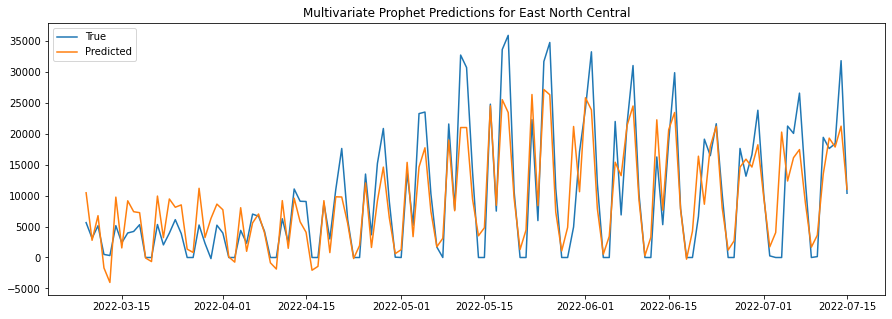


Training model for East South Central...
MAE: 1954.11
MSE: 8135815.22
RMSE: 2852.34
MASE: 0.54


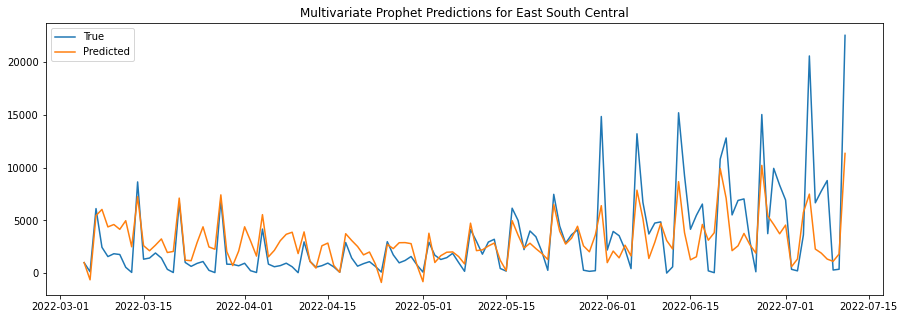


Training model for Mid-Atlantic...


Optimization terminated abnormally. Falling back to Newton.


MAE: 3393.7
MSE: 24002923.16
RMSE: 4899.28
MASE: 1.49


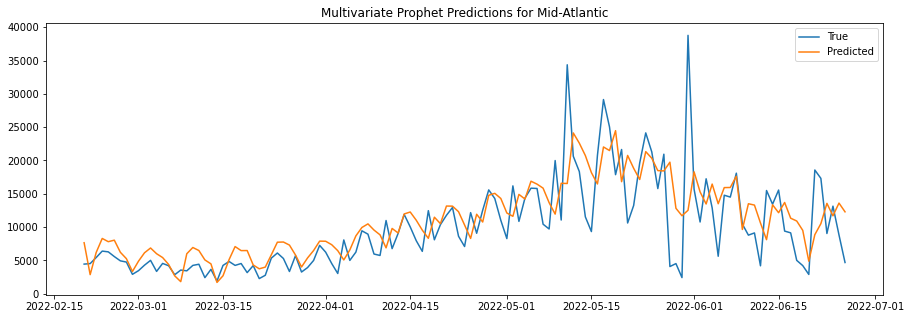


Training model for Mountain...
MAE: 2864.42
MSE: 19600626.39
RMSE: 4427.26
MASE: 0.86


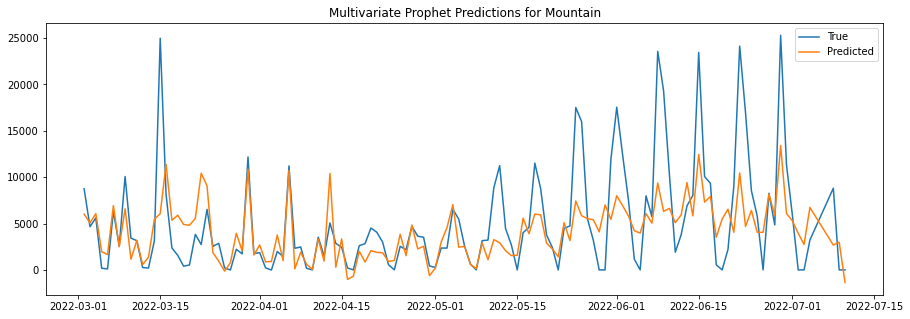


Training model for New England...
MAE: 1394.13
MSE: 4987288.06
RMSE: 2233.22
MASE: 0.52


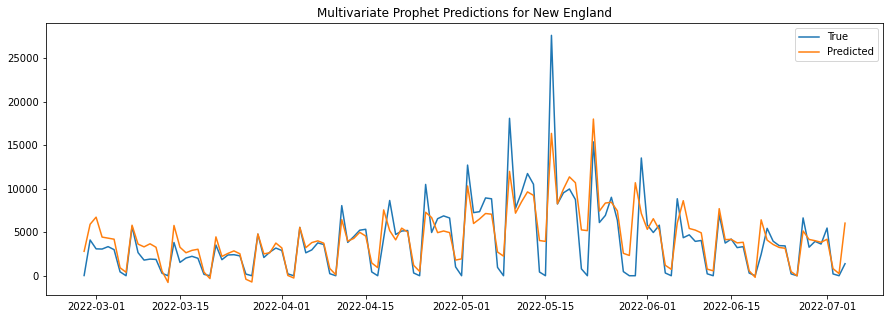


Training model for Pacific...


Optimization terminated abnormally. Falling back to Newton.


MAE: 7711.62
MSE: 133229307.93
RMSE: 11542.5
MASE: 1.07


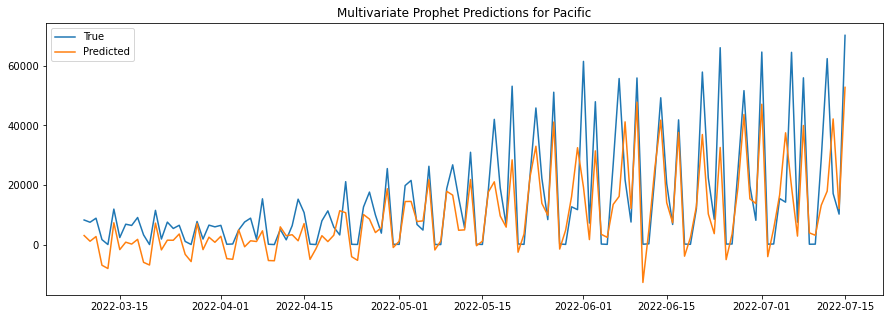


Training model for South Atlantic...


Optimization terminated abnormally. Falling back to Newton.


MAE: 6555.62
MSE: 89724755.19
RMSE: 9472.32
MASE: 0.57


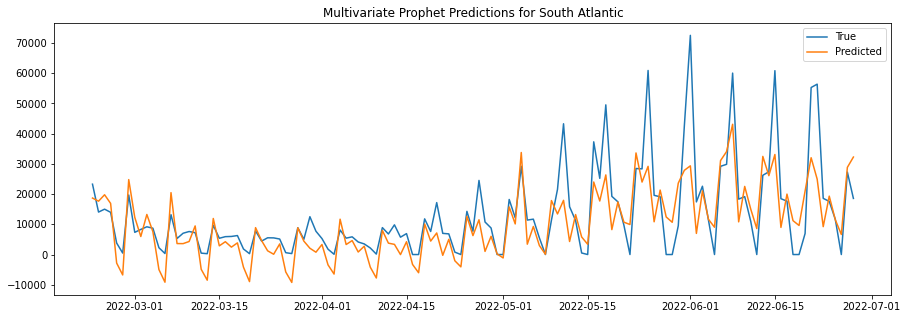


Training model for West North Central...


Optimization terminated abnormally. Falling back to Newton.


MAE: 2353.74
MSE: 11094190.41
RMSE: 3330.79
MASE: 0.69


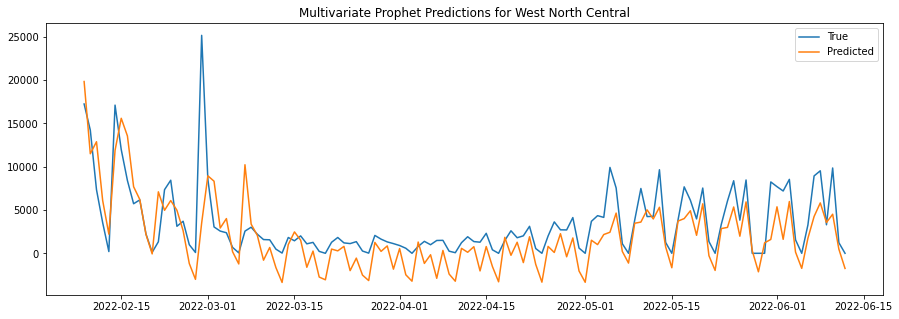


Training model for West South Central...
MAE: 2240.24
MSE: 11335787.59
RMSE: 3366.87
MASE: 0.46


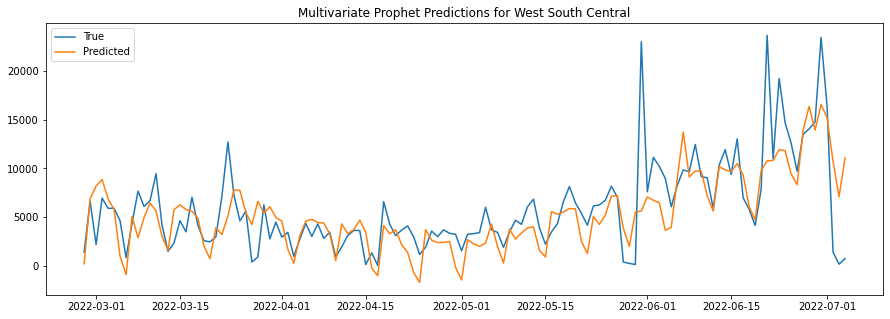


--- 19.11 seconds ---


In [90]:
start_time = time.time()
for df in datasets:
    region = df["region"].iloc[0]
    build_final_multi_prophet(df, features=final_params[region]["features"], params=final_params[region]["params"], plot=True)
    print("")
print(f"--- {round(time.time() - start_time, 2)} seconds ---")